In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Using deep learning to classify Landmark in Vietnam
### Phân loại các danh lam thắng cảnh ở Việt Nam bằng mạng học sâu nơ-ron tích chập CNN

---


## **Ý tưởng giải pháp:**
Để phân loại các danh lam thắng cảnh sử dụng deep learning, phương pháp được lựa chọn dựa trên transfer learning : sử dụng mô hình CNN kết hợp với mô hình VGG16 được huấn luyện trên tập dữ liệu ImageNet và fine-tuning trên tập dữ liệu phân loại danh lam thắng cảnh. Đây là bài toán phân loại đa lớp nên hàm mất mát được sử dụng ở đây là Categorical Cross Entropy. Categorical Cross Entropy tính toán tổng của các khác biệt logarit giữa các xác suất dự đoán và xác suất thực tế cho tất cả các lớp của bài toán.
Convolutional Neural Network là một kiến trúc mạng neuron cơ bản được sử dụng để xử lý hình ảnh. CNN sử dụng các lớp convolutional, pooling và fully-connected để học các đặc trưng của hình ảnh và phân loại chúng. VGG16 là một mạng CNN tiên tiến được huấn luyện trên một số lượng lớn các hình ảnh để phân loại các đối tượng trong ảnh.


## Data preparation and preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler, Callback

In [ ]:
root_folder = '/content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train'
class_subset = sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train'))
print(class_subset)
len(class_subset)

['bao_tang_ha_noi', 'buu_dien_trung_tam_tphcm', 'cau_long_bien', 'cau_nhat_tan', 'cau_rong', 'cho_ben_thanh_tphcm', 'chua_cau', 'chua_mot_cot', 'chua_thien_mu', 'cot_co', 'hoang_thanh', 'hon_chong_nhatrang', 'landmark81', 'lang_bac', 'lang_khai_dinh', 'mui_ca_mau', 'mui_ke_ga_phanthiet', 'nha_hat_lon_hanoi', 'nha_hat_lon_tphcm', 'nha_tho_da_co_sapa', 'nha_tho_lon_ha_noi', 'quang_truong_lam_vien', 'suoi_tien_tphcm', 'thac_ban_gioc', 'thap_cham', 'thap_rua', 'toa_nha_bitexco_tphcm', 'tuong_chua_kito_vungtau', 'ubnd_tphcm', 'van_mieu']


30

In [ ]:
def print_directory_structure(folder_path, prefix='', count=False):
    folder_name = os.path.basename(folder_path)
    print(f"{prefix}+--{folder_name}/")
    if os.path.isdir(folder_path):
        folder_contents = os.listdir(folder_path)
        is_leaf = True
        for content in folder_contents:
            content_path = os.path.join(folder_path, content)
            if os.path.isdir(content_path):
                is_leaf = False
                break
        if is_leaf:
            file_count = len(folder_contents)
        else:
            for content in folder_contents:
                content_path = os.path.join(folder_path, content)
                if os.path.isdir(content_path):
                    print_directory_structure(content_path, prefix + "    ", count=count)

folder_path = "/content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification"

# Print directory structure
print_directory_structure(folder_path, count=True)


+--Landmark_Classification/
    +--train/
        +--thap_rua/
        +--suoi_tien_tphcm/
        +--cau_nhat_tan/
        +--mui_ca_mau/
        +--quang_truong_lam_vien/
        +--mui_ke_ga_phanthiet/
        +--chua_thien_mu/
        +--buu_dien_trung_tam_tphcm/
        +--lang_khai_dinh/
        +--van_mieu/
        +--nha_hat_lon_tphcm/
        +--cau_long_bien/
        +--chua_cau/
        +--tuong_chua_kito_vungtau/
        +--bao_tang_ha_noi/
        +--hoang_thanh/
        +--cot_co/
        +--ubnd_tphcm/
        +--hon_chong_nhatrang/
        +--nha_hat_lon_hanoi/
        +--thac_ban_gioc/
        +--cau_rong/
        +--cho_ben_thanh_tphcm/
        +--nha_tho_da_co_sapa/
        +--chua_mot_cot/
        +--toa_nha_bitexco_tphcm/
        +--thap_cham/
        +--landmark81/
        +--nha_tho_lon_ha_noi/
        +--lang_bac/
    +--test/
        +--chua_thien_mu/
        +--cau_nhat_tan/
        +--van_mieu/
        +--thap_rua/
        +--quang_truong_lam_vien/
        +-

In [ ]:
total_image_count = 0
for dirpath, dirnames, filenames in os.walk(root_folder):
    num_images = len([f for f in filenames if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')])
    total_image_count += num_images
    print(f"Folder {dirpath} contains {num_images} images")
print(f"Total number of images: {total_image_count}")

Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train contains 0 images
Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train/thap_rua contains 40 images
Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train/suoi_tien_tphcm contains 50 images
Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train/cau_nhat_tan contains 50 images
Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train/mui_ca_mau contains 42 images
Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train/quang_truong_lam_vien contains 49 images
Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train/mui_ke_ga_phanthiet contains 50 images
Folder /content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train/chua_thien_mu contains 24 images
Folder /content/drive/MyDrive/Colab Note

In [ ]:
#Data Augmentation
train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.9], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=30,           # random rotation by 30 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.10        # 10% of the data will be used for validation at end of each epoch
)

In [ ]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train',
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/train',
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 1086 images belonging to 30 classes.
Found 108 images belonging to 30 classes.


In [ ]:
train_filenames = set(traingen.filenames)
valid_filenames = set(validgen.filenames)

# Check if there are any common elements between train and valid filenames
intersection = train_filenames.intersection(valid_filenames)
print(f"Number of duplicate images: {len(intersection)}")
# Check the number of images in train and valid
print(f"Number of images in train: {len(train_filenames)}")
print(f"Number of images in valid: {len(valid_filenames)}")

Number of duplicate images: 0
Number of images in train: 1086
Number of images in valid: 108


## Model development


In [ ]:
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze some layers of the pre-trained model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add new layers on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(class_subset), activation='softmax')) #output layer

model.summary() # a handy way to inspect the architecture


58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 30)                61470     
                                                                 
Total params: 66,158,430
Trainable params: 58,523,166
Non-trainable params: 7,635,264
_____________________________________

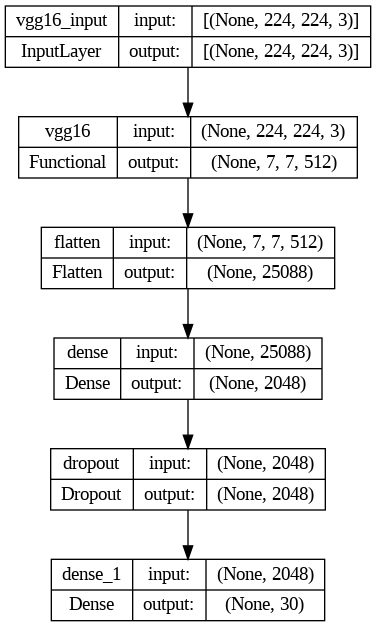

In [ ]:
plot_model(model, to_file="cnn.png", show_shapes=True)

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


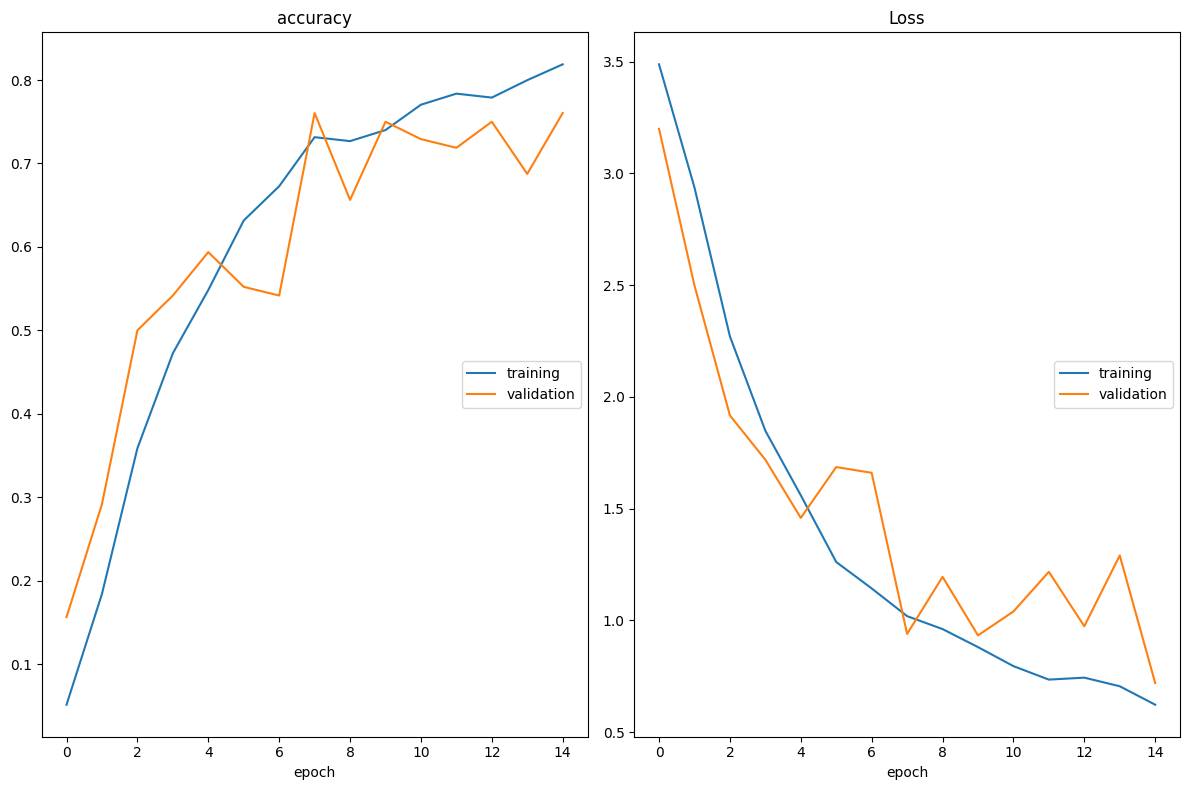

accuracy
	training         	 (min:    0.051, max:    0.819, cur:    0.819)
	validation       	 (min:    0.156, max:    0.760, cur:    0.760)
Loss
	training         	 (min:    0.623, max:    3.488, cur:    0.623)
	validation       	 (min:    0.720, max:    3.199, cur:    0.720)
CPU times: user 10min 22s, sys: 30.5 s, total: 10min 53s
Wall time: 27min 37s


In [ ]:
%%time

from livelossplot import PlotLossesKeras


steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 15

#optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

## Model evaluatation

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Final_LTTNT/Landmark_Classification/test',
                                             target_size=(224, 224),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)

Found 1503 images belonging to 30 classes.


In [ ]:
model.load_weights('img_model.weights.best.hdf5')

predicted_classes = np.argmax(model.predict(testgen), axis=-1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

1503/1503 [==============================] - 867s 577ms/step


In [ ]:
def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

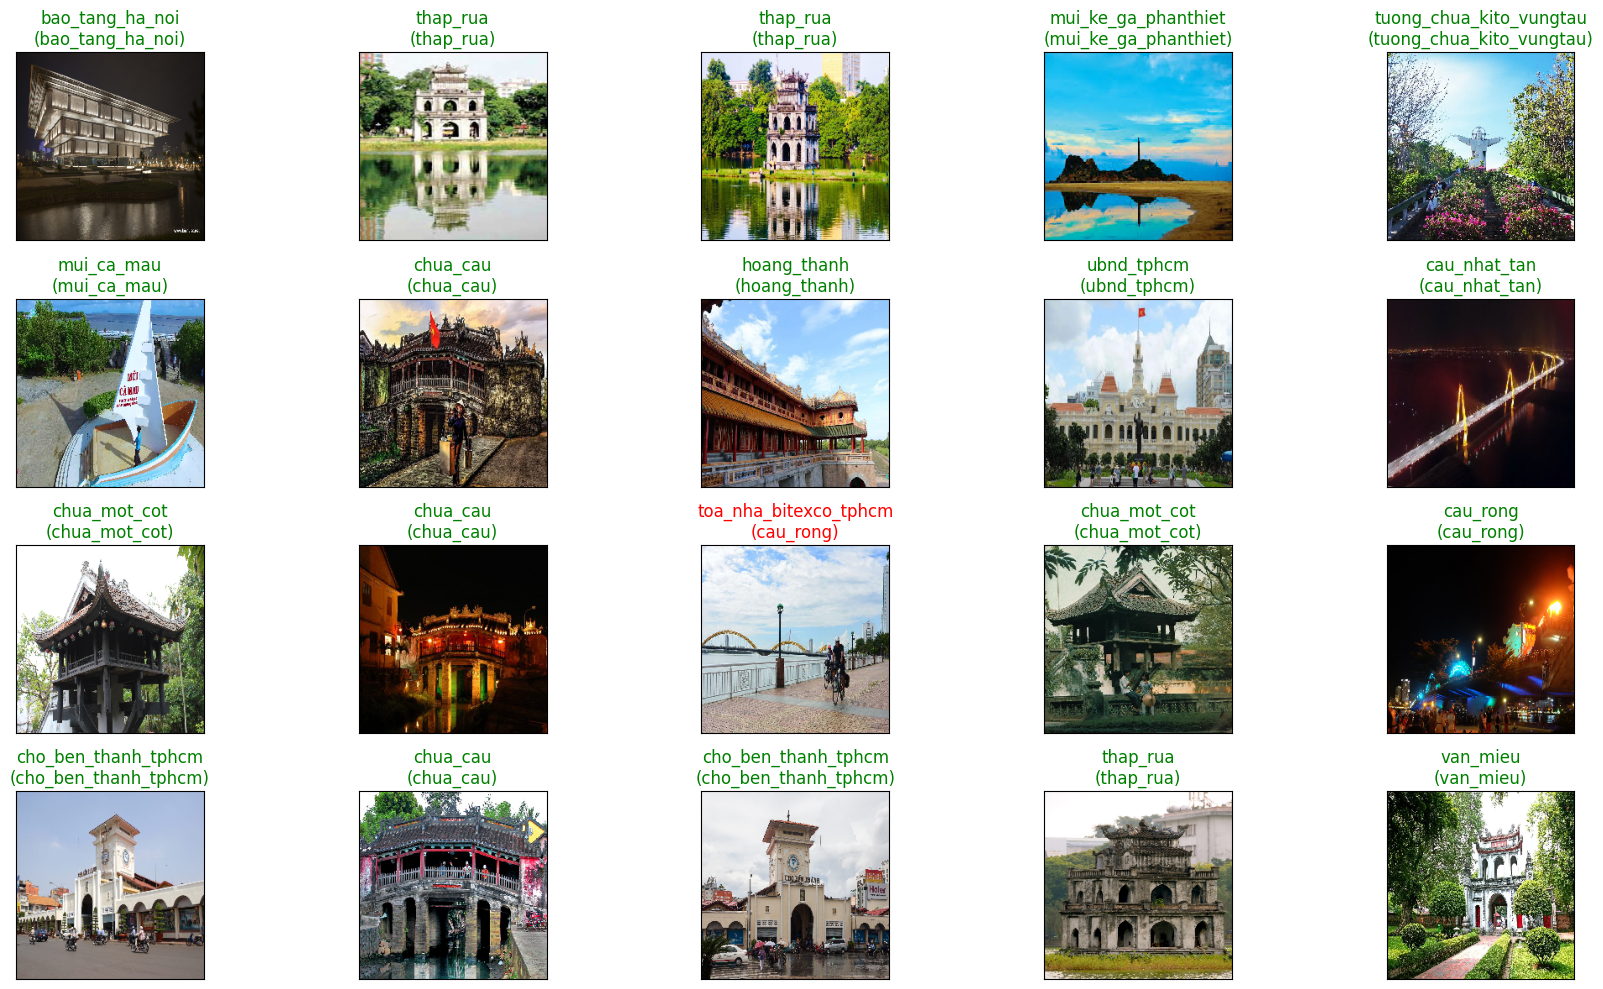

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 86.63%


,Precision,Recall,F-Score,Support
cau_long_bien,0.979167,0.940000,0.959184,50.0
cau_nhat_tan,0.979167,0.940000,0.959184,50.0
nha_tho_lon_ha_noi,1.000000,0.920000,0.958333,50.0
nha_hat_lon_tphcm,0.978261,0.900000,0.937500,50.0
thap_cham,0.905660,0.960000,0.932039,50.0
nha_tho_da_co_sapa,0.921569,0.940000,0.930693,50.0
lang_bac,0.977778,0.880000,0.926316,50.0
chua_mot_cot,0.920000,0.920000,0.920000,50.0
bao_tang_ha_noi,0.886792,0.940000,0.912621,50.0
ubnd_tphcm,0.857143,0.960000,0.905660,50.0
